# Analysis & Visualization Notebook

Now that we have our final dataset to work with, let's make some pretty graphs!

We are going to run analyses on Year, Runtime, Genre, IMDB Rating, Director, and Actor. We want to see the effect of these features on profitability as measured by the average gross profit, and the average ROI.

### Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
plt.style.use(['ggplot', 'dark_background'])
sns.set_palette('viridis')
import warnings
warnings.simplefilter('ignore')

### Load in & prep the data

In [2]:
# Read in and display master data
df = pd.read_csv('../cleanedData/master_data.csv')

df.head(1)

,Unnamed: 0,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,Title & Year,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,0,Avatar,425000000.00,760507625.00,2776345279.00,2009,2351345279.00,5.53,Avatar - 2009,tt0499549,162,"Action,Adventure,Fantasy",7.90,1359426.00,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau


We can get this to look a little better before we start matplotlibbing. Let's drop a couple columns and make sure all data is ready for easy analysis.

In [3]:
# Delete these columns
del df['Unnamed: 0']
del df['Title & Year']
    
# Convert Runtime to integer after replacing some unknowns and nulls with zero
df['Runtime'] = df['Runtime'].replace('\\N', '0')
df['Runtime'] = df['Runtime'].fillna('0')
df['Runtime'] = df['Runtime'].astype(float).astype(int)

df.head(1)

,Title,Budget,Domestic_Gross_Rev,Global_Gross_Rev,Year,Global_Gross_Profit,Global_Gross_ROI,ID,Runtime,Genres,AvgRating,VoteCount,Actors,Writers,Directors,Producers
0,Avatar,425000000.00,760507625.00,2776345279.00,2009,2351345279.00,5.53,tt0499549,162,"Action,Adventure,Fantasy",7.90,1359426.00,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",NaN,James Cameron,Jon Landau


Looks great. Let's get a look at some of the most profitable movies to get the blood flowing.

### Most profitable films 

#### Formats for table displays

In [4]:
# Formatting float datatypes
formats = {'Budget': '${:,.0f}', 'Domestic_Gross_Rev': '${:,.0f}', 'Global_Gross_Rev': '${:,.0f}', 
           'Global_Gross_Profit': '${:,.0f}', 'Global_Gross_ROI': '{:.1f}x', 'AvgRating': '{:.2f}',
           'VoteCount': '{:.0f}'}

In [5]:
highest_profit_films = df[['Title', 'Global_Gross_Profit']].sort_values(
                         ['Global_Gross_Profit'], ascending=False).head(5)

highest_profit_films.style.format(formats).hide_index()

Title,Global_Gross_Profit
Avatar,"$2,351,345,279"
Avengers: Infinity War,"$1,748,134,200"
Jurassic World,"$1,433,854,864"
Furious 7,"$1,328,722,794"
The Avengers,"$1,292,935,897"


So for our dataset, these are the 5 most profitable by gross profit.

In [6]:
highest_ROI_films = df[['Title', 'Global_Gross_ROI']].sort_values(
                      ['Global_Gross_ROI'], ascending=False).head(5)
highest_ROI_films.style.format(formats).hide_index()

Title,Global_Gross_ROI
The Gallows,415.6x
Super Size Me,341.1x
Once,154.5x
Primer,119.3x
Napoleon Dynamite,114.3x


And these are the most profitable by return on investment, calculated as (gross profit / production cost).

### Profit by year

Let's see if we have have any trends over time.

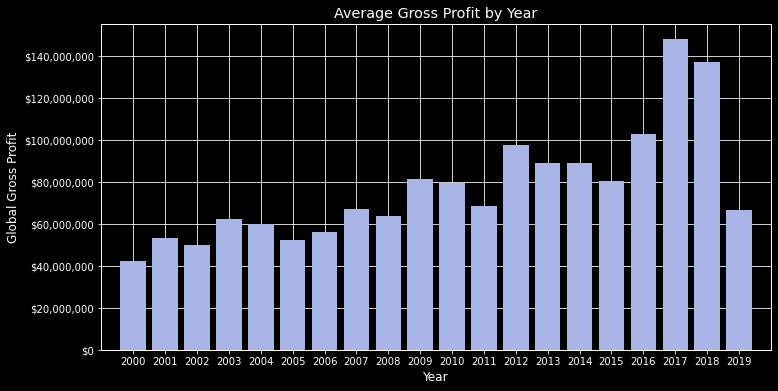

In [29]:
# Average Gross Profit by Year
profit_by_year = df[['Year', 'Global_Gross_Profit']].groupby('Year').mean()

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(profit_by_year.index, profit_by_year['Global_Gross_Profit'], width=0.8, color='#a9b4e7')

ax.set_xlabel('Year')
ax.set_xticks(profit_by_year.index)
ax.set_xlim(1999, 2020)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Average Gross Profit by Year')

plt.show();

So we do see pretty substantial growth. We suspect that the drop off in 2019 is due to having incomplete data at the time this dataset was compiled.

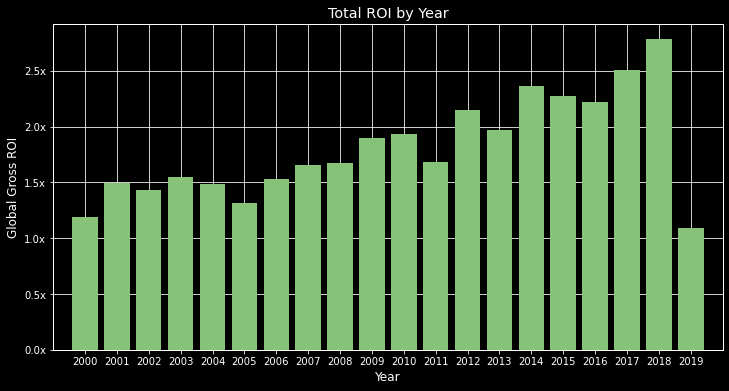

In [8]:
# Total ROI by Year
ROI_by_year = df[['Year', 'Global_Gross_Profit', 'Budget']].groupby('Year').sum()
ROI_by_year['ROI'] = ROI_by_year['Global_Gross_Profit'] / ROI_by_year['Budget']

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(ROI_by_year.index, ROI_by_year['ROI'], width=0.8, color='#86c277')

ax.set_xlabel('Year')
ax.set_xticks(ROI_by_year.index)
ax.set_xlim(1999, 2020)

ax.set_ylabel('Global Gross ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI by Year')

plt.show();

We also note an upward trend here. Looks like studios have gotten more efficient with their money over time.

### Profit by runtime

We wonder if people are drawn more to a certain length of film?

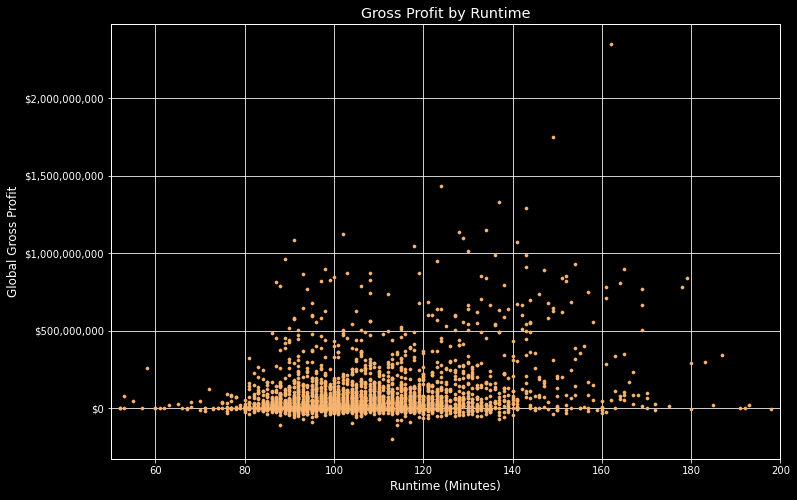

In [9]:
# Profit by runtime
runtime_profit = df[['Runtime', 'Global_Gross_Profit']]

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(runtime_profit['Runtime'], runtime_profit['Global_Gross_Profit'], s=10, color='#f7b370')

ax.set_xlabel('Runtime (Minutes)')
ax.set_xlim(50, 200)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Gross Profit by Runtime')

plt.show();

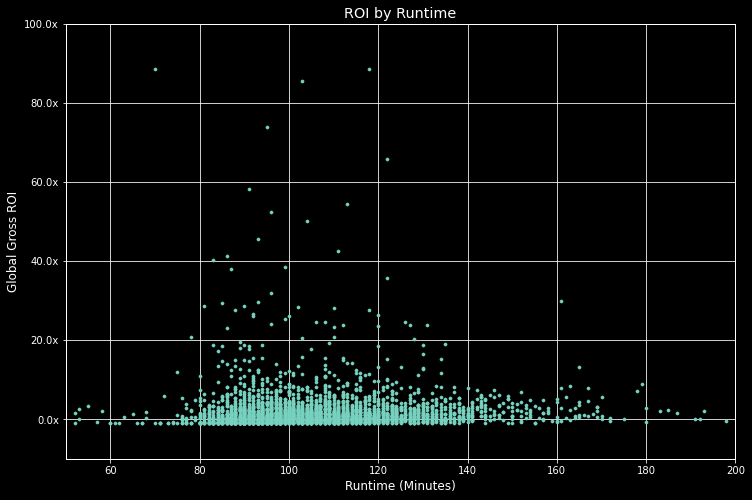

In [10]:
# ROI by runtime
runtime_ROI = df[['Runtime', 'Global_Gross_ROI']]

fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(runtime_ROI['Runtime'], runtime_ROI['Global_Gross_ROI'], s=10, color='#77d1bf')

ax.set_xlabel('Runtime (Minutes)')
ax.set_xlim(50, 200)

ax.set_ylabel('Global Gross ROI')
ax.set_ylim(-10, 100)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('ROI by Runtime')

plt.show();

There doesn't appear to be any significant pattern.

### Profit by genre

Now let's look at which genres generate the most money. We will have to get a little creative to parse out the individual genres.

In [11]:
# New df to work with
genres_exploded = df[['Title', 'Genres', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
genres_exploded['Genres'] = genres_exploded['Genres'].fillna("")

# Use .apply to parse the elements into a list
genres_exploded['Genres'] = genres_exploded['Genres'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual genres
genres_exploded = genres_exploded.explode('Genres')

# Remove null genres
genres_exploded = genres_exploded[genres_exploded['Genres'] != ""]

# Remove single instance of 'News' genre that leads to outlier in analysis
genres_exploded = genres_exploded[genres_exploded['Genres'] != "News"]

genres_exploded.head(10)

,Title,Genres,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,Action,2351345279.00,5.53,425000000.00
0,Avatar,Adventure,2351345279.00,5.53,425000000.00
0,Avatar,Fantasy,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Action,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Adventure,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Fantasy,635063875.00,1.55,410600000.00
2,Dark Phoenix,Action,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Adventure,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Sci-Fi,-200237650.00,-0.57,350000000.00
3,Avengers: Age of Ultron,Action,1072413963.00,3.24,330600000.00


Sweet! Now let's do some groupbys and graphs.

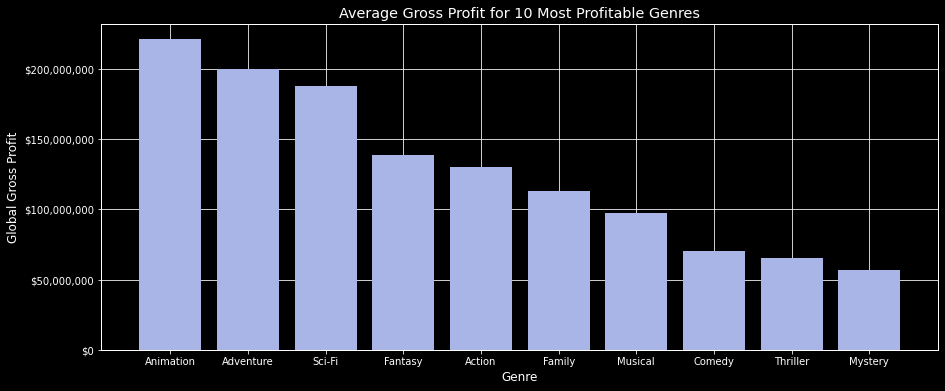

In [21]:
# Average Gross Profit by Genre
profit_by_genre = genres_exploded.groupby('Genres').mean().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(profit_by_genre.index, profit_by_genre['Global_Gross_Profit'], width=0.8, color='#a9b4e7')

ax.set_xlabel('Genre')
ax.set_xticks(profit_by_genre.index)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Average Gross Profit for 10 Most Profitable Genres')

plt.savefig("../Images/avg_gp_genre.png", dpi=150)
plt.show();

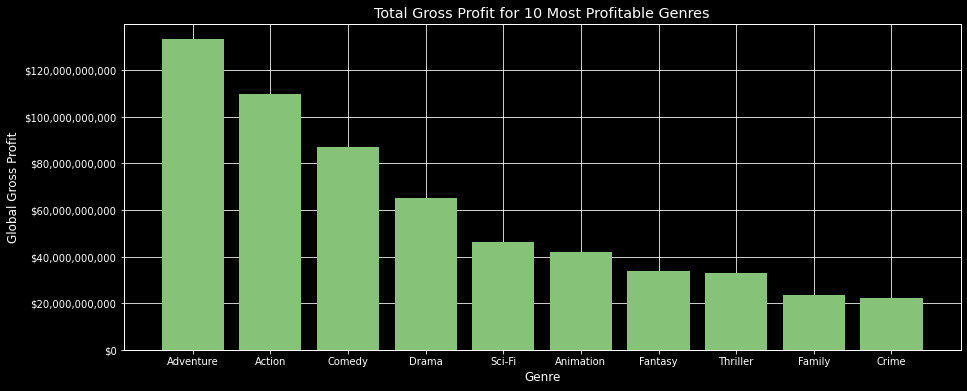

In [22]:
# Total Gross Profit by Genre
profit_by_genre = genres_exploded.groupby('Genres').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(profit_by_genre.index, profit_by_genre['Global_Gross_Profit'], width=0.8, color='#86c277')

ax.set_xlabel('Genre')
ax.set_xticks(profit_by_genre.index)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for 10 Most Profitable Genres')

plt.savefig("../Images/total_gp_genre.png", dpi=150)
plt.show();

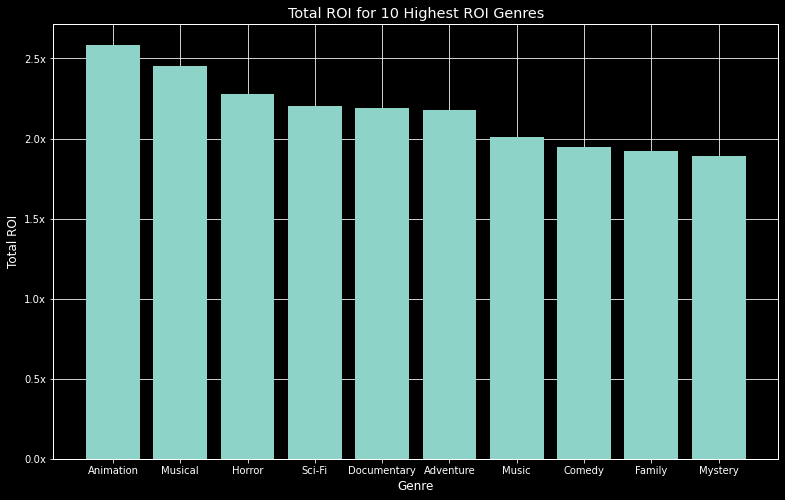

In [14]:
# Total ROI by Genre
ROI_by_genre = genres_exploded.groupby('Genres').sum()
ROI_by_genre['ROI'] = ROI_by_genre['Global_Gross_Profit'] / ROI_by_genre['Budget']
ROI_by_genre = ROI_by_genre.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 8))

ax.bar(ROI_by_genre.index, ROI_by_genre['ROI'], width=0.8)

ax.set_xlabel('Genre')
ax.set_xticks(ROI_by_genre.index)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI for 10 Highest ROI Genres')

plt.show();

### Profit by director

We'll do the same process we did for genres here.

In [15]:
# New df to work with
directors_exploded = df[['Title', 'Directors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
directors_exploded['Directors'] = directors_exploded['Directors'].fillna("")

# Use .apply to parse the elements into a list
directors_exploded['Directors'] = directors_exploded['Directors'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual directors
directors_exploded = directors_exploded.explode('Directors')

# Remove null directors
directors_exploded = directors_exploded[directors_exploded['Directors'] != ""]

directors_exploded.head(10)

,Title,Directors,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,James Cameron,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Rob Marshall,635063875.00,1.55,410600000.00
2,Dark Phoenix,Simon Kinberg,-200237650.00,-0.57,350000000.00
3,Avengers: Age of Ultron,Joss Whedon,1072413963.00,3.24,330600000.00
4,Avengers: Infinity War,Anthony Russo,1748134200.00,5.83,300000000.00
4,Avengers: Infinity War,Joe Russo,1748134200.00,5.83,300000000.00
5,Pirates of the Caribbean: At World's End,Gore Verbinski,663420425.00,2.21,300000000.00
6,Justice League,Zack Snyder,355945209.00,1.19,300000000.00
7,Spectre,Sam Mendes,579620923.00,1.93,300000000.00
8,The Dark Knight Rises,Christopher Nolan,809439099.00,2.94,275000000.00


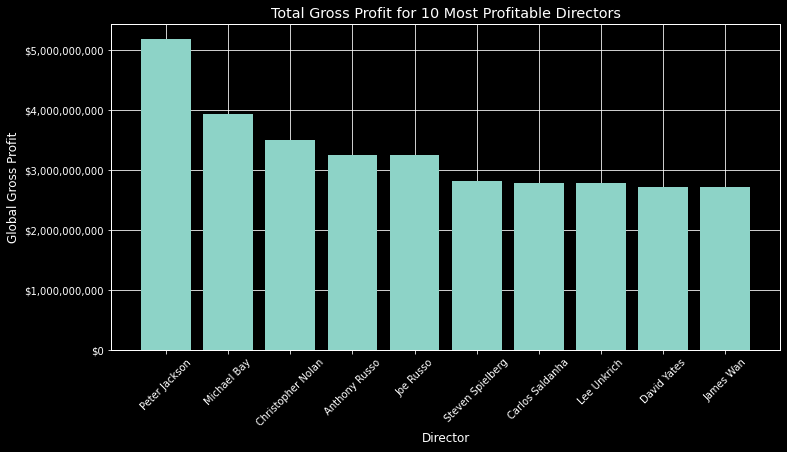

In [16]:
# Total Gross Profit by Director
profit_by_director = directors_exploded.groupby('Directors').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(profit_by_director.index, profit_by_director['Global_Gross_Profit'], width=0.8)

ax.set_xlabel('Director')
ax.set_xticks(profit_by_director.index)
plt.xticks(rotation=45)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for 10 Most Profitable Directors')

plt.show();

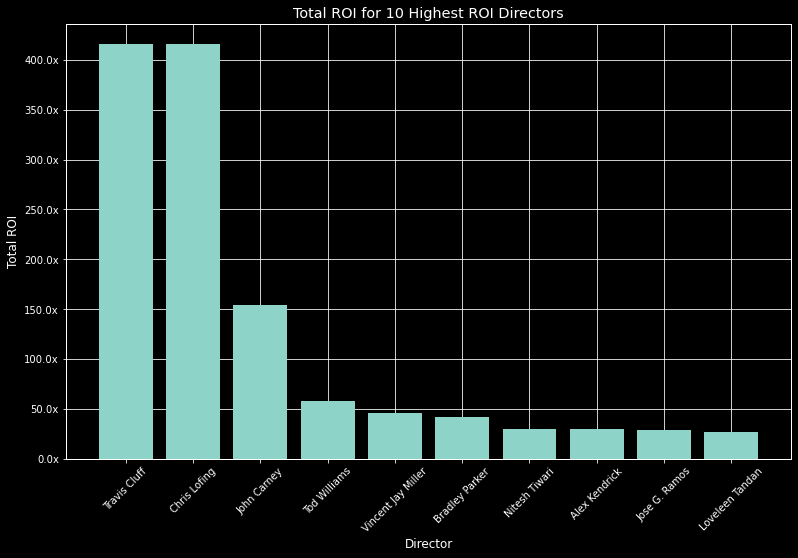

In [17]:
# Total ROI by Director
ROI_by_director = directors_exploded.groupby('Directors').sum()
ROI_by_director['ROI'] = ROI_by_director['Global_Gross_Profit'] / ROI_by_director['Budget']
ROI_by_director = ROI_by_director.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 8))

ax.bar(ROI_by_director.index, ROI_by_director['ROI'], width=0.8)

ax.set_xlabel('Director')
ax.set_xticks(ROI_by_director.index)
plt.xticks(rotation=45)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI for 10 Highest ROI Directors')

plt.show();

### Profit by actor

We'll do the same process we did for genres here.

In [18]:
# New df to work with
actors_exploded = df[['Title', 'Actors', 'Global_Gross_Profit', 'Global_Gross_ROI', 'Budget']]

# Fill null values to apply lambda function
actors_exploded['Actors'] = actors_exploded['Actors'].fillna("")

# Use .apply to parse the elements into a list
actors_exploded['Actors'] = actors_exploded['Actors'].apply(lambda x: x.split(","))

# Use .explode to pull out indvidual actors
actors_exploded = actors_exploded.explode('Actors')

# Remove null actors
actors_exploded = actors_exploded[actors_exploded['Actors'] != ""]

actors_exploded.head(10)

,Title,Actors,Global_Gross_Profit,Global_Gross_ROI,Budget
0,Avatar,Sam Worthington,2351345279.00,5.53,425000000.00
0,Avatar,Zoe Saldana,2351345279.00,5.53,425000000.00
0,Avatar,Sigourney Weaver,2351345279.00,5.53,425000000.00
0,Avatar,Michelle Rodriguez,2351345279.00,5.53,425000000.00
1,Pirates of the Caribbean: On Stranger Tides,Johnny Depp,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Penélope Cruz,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Ian McShane,635063875.00,1.55,410600000.00
1,Pirates of the Caribbean: On Stranger Tides,Geoffrey Rush,635063875.00,1.55,410600000.00
2,Dark Phoenix,James McAvoy,-200237650.00,-0.57,350000000.00
2,Dark Phoenix,Michael Fassbender,-200237650.00,-0.57,350000000.00


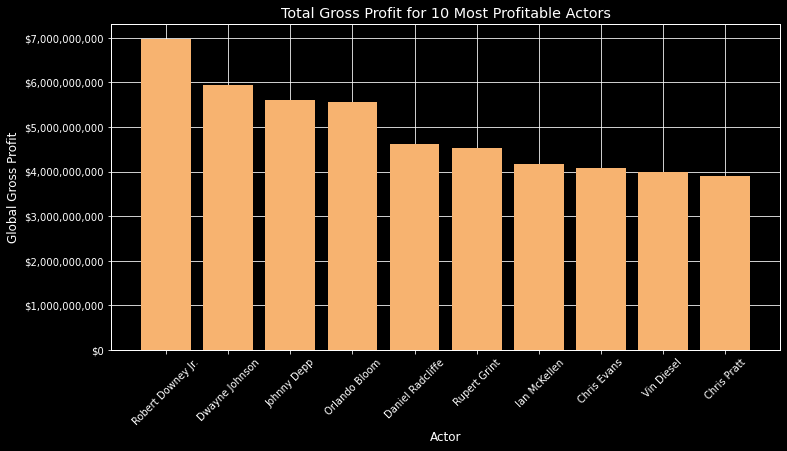

In [19]:
# Total Gross Profit by Actor
profit_by_actor = actors_exploded.groupby('Actors').sum().sort_values(
                  'Global_Gross_Profit', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(profit_by_actor.index, profit_by_actor['Global_Gross_Profit'], width=0.8, color='#f7b370')

ax.set_xlabel('Actor')
ax.set_xticks(profit_by_actor.index)
plt.xticks(rotation=45)

ax.set_ylabel('Global Gross Profit')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

ax.set_title('Total Gross Profit for 10 Most Profitable Actors')

plt.show();

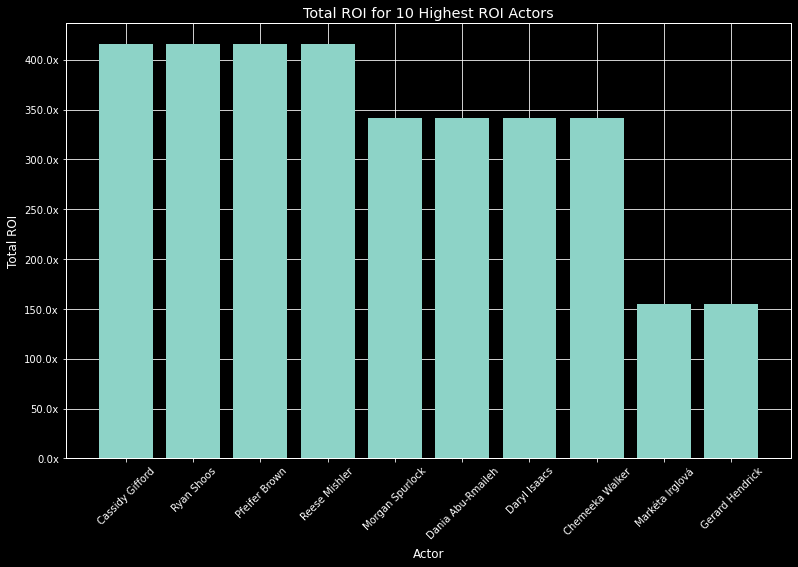

In [20]:
# Total ROI by Actor
ROI_by_actor = actors_exploded.groupby('Actors').sum()
ROI_by_actor['ROI'] = ROI_by_actor['Global_Gross_Profit'] / ROI_by_actor['Budget']
ROI_by_actor = ROI_by_actor.sort_values('ROI', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(13, 8))

ax.bar(ROI_by_actor.index, ROI_by_actor['ROI'], width=0.8)

ax.set_xlabel('Actor')
ax.set_xticks(ROI_by_actor.index)
plt.xticks(rotation=45)

ax.set_ylabel('Total ROI')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}x'))

ax.set_title('Total ROI for 10 Highest ROI Actors')

plt.show();